In [1]:
#importing libraries
import tensorflow as tf #deep learning lib
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt #plotting our plots

In [2]:
import keras #for using keras preprocessing and other functions

In [3]:
#input size
img_size = 255
batches = 32
channels = 3


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/july2023/Farhan_crop_disease/code/data/cotton"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [6]:
#changing the working directory
%cd /content/drive/MyDrive/july2023/Farhan_crop_disease/code/data/cotton
#Check the present working directory using pwd command

/content/drive/MyDrive/july2023/Farhan_crop_disease/code/data/cotton


In [10]:
!kaggle datasets download -d janmejaybhoi/cotton-disease-dataset

 93% 138M/148M [00:01<00:00, 107MB/s] 
100% 148M/148M [00:01<00:00, 82.0MB/s]


In [9]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [10]:
#creating batches for train , val , test
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/july2023/Farhan_crop_disease/code/data/cotton/Cotton Disease/train",
    shuffle = True,
    image_size =(img_size,img_size),
    batch_size = batches,
)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/july2023/Farhan_crop_disease/code/data/cotton/Cotton Disease/test",
    shuffle = True,
    image_size =(img_size,img_size),
    batch_size = batches,

)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/july2023/Farhan_crop_disease/code/data/cotton/Cotton Disease/val",
    shuffle = True,
    image_size =(img_size,img_size),
    batch_size = batches,

)



Found 1951 files belonging to 4 classes.
Found 106 files belonging to 4 classes.
Found 253 files belonging to 4 classes.


In [11]:
len(training_ds),len(valid_ds),len(testing_ds)

(61, 8, 4)

### optimizing

In [12]:
train_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
test_ds = testing_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.experimental.AUTOTUNE )

### Data Augmentation

In [13]:
data_augmentations = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/img_size),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)

])

### Creating model

In [14]:
inputshape = (batches ,img_size , img_size , 3)
classes = 4

plant_model = keras.models.Sequential([
    data_augmentations,
    layers.Conv2D(filters = 32 , kernel_size = (3 , 3),activation = 'relu' , input_shape = inputshape),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 64 , kernel_size = (3,3)  , activation ='relu'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 128 , kernel_size = (3,3) , activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 256, kernel_size = (3,3) , activation = 'relu'),
    layers.MaxPooling2D(pool_size = (2,2)),

    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(units = 128 , activation = 'relu'),
    layers.Dropout(0.1),
    layers.Dense(units = 128 , activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(units = classes , activation = 'softmax'),

])

plant_model.build(input_shape = inputshape)

In [15]:
plant_model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) , metrics = ['accuracy'])

### Model params

In [16]:
plant_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 255, 255, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 128)        

### Training

In [17]:
EPOCHS = 300

In [18]:
#saving models everytime we get a better val_accuracy
checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'

In [19]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = plant_model.fit(
    train_ds,
    callbacks = [model_checkpoint_callback],
    epochs = EPOCHS,
    verbose = 1,
    validation_data = valid_ds
)

Epoch 1/300


2022-06-08 15:40:04.660140: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-08 15:40:14.923892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 52 of 1000
2022-06-08 15:40:15.211827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-06-08 15:40:15.997234: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


61/61 [==============================] - 24s 82ms/step - loss: 1.1626 - accuracy: 0.4921 - val_loss: 1.0063 - val_accuracy: 0.5494
Epoch 2/300
61/61 [==============================] - 3s 41ms/step - loss: 0.9926 - accuracy: 0.5971 - val_loss: 1.1936 - val_accuracy: 0.5217
Epoch 3/300
61/61 [==============================] - 2s 41ms/step - loss: 0.8557 - accuracy: 0.6494 - val_loss: 0.7099 - val_accuracy: 0.7984
Epoch 4/300
61/61 [==============================] - 3s 41ms/step - loss: 0.6361 - accuracy: 0.7319 - val_loss: 0.4528 - val_accuracy: 0.7826
Epoch 5/300
61/61 [==============================] - 2s 41ms/step - loss: 0.5463 - accuracy: 0.7714 - val_loss: 0.4158 - val_accuracy: 0.8340
Epoch 6/300
61/61 [==============================] - 3s 42ms/step - loss: 0.4846 - accuracy: 0.8047 - val_loss: 0.3567 - val_accuracy: 0.8577
Epoch 7/300
61/61 [==============================] - 2s 41ms/step - loss: 0.4925 - accuracy: 0.7970 - val_loss: 0.2972 - val_accuracy: 0.8814
Epoch 8/300
61/61

In [ ]:
scores = plant_model.evaluate(test_ds)

4/4 [==============================] - 2s 15ms/step - loss: 0.0623 - accuracy: 0.9717


In [ ]:
scores

[0.062330462038517, 0.9716981053352356]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 300, 'steps': 61}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Plotting

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

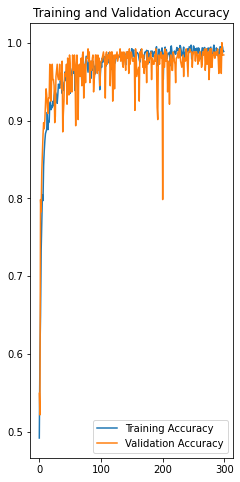

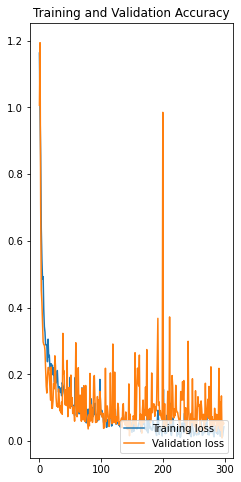

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot( 1 , 2 , 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize = (8,8))
plt.subplot( 1 , 2 , 1)
plt.plot(range(EPOCHS), loss, label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.show()

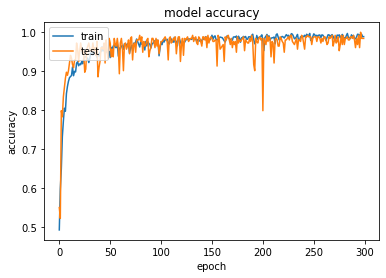

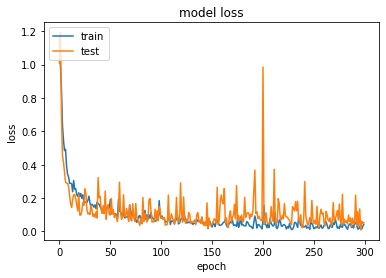

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predicted123 = plant_model.predict(test_ds)

In [ ]:
plant_model.evaluate(test_ds)

4/4 [==============================] - 0s 12ms/step - loss: 0.0623 - accuracy: 0.9717


[0.062330462038517, 0.9716981053352356]

In [ ]:
predictions = plant_model.predict_generator(test_ds)
predictions

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([[1.60677749e-17, 9.99999881e-01, 3.15207091e-15, 7.99579851e-08],
       [8.14272334e-25, 2.41143707e-14, 1.18193834e-12, 1.00000000e+00],
       [1.29178043e-10, 2.65686485e-05, 7.82190568e-07, 9.99972582e-01],
       [5.90372404e-11, 2.80300561e-09, 1.00000000e+00, 1.61066882e-09],
       [1.42643533e-23, 1.00000000e+00, 4.10206876e-15, 6.07602679e-09],
       [1.00000000e+00, 2.25442740e-24, 2.84235225e-15, 4.11176518e-23],
       [2.78822972e-13, 3.83202720e-10, 1.00000000e+00, 7.44342499e-09],
       [7.45418701e-13, 9.99974370e-01, 1.36048683e-09, 2.56414496e-05],
       [5.16188699e-26, 1.00000000e+00, 1.71996230e-20, 1.65898302e-11],
       [1.74320485e-06, 9.23224986e-01, 2.21254799e-04, 7.65519366e-02],
       [8.31363600e-15, 1.40276096e-10, 1.00000000e+00, 4.27934424e-12],
       [1.16006152e-20, 2.73915557e-09, 1.05915398e-11, 1.00000000e+00],
       [1.63790863e-14, 1.08400282e-10, 1.00000000e+00, 3.46876542e-12],
       [1.38792545e-01, 1.39607454e-03, 8.59730065e

In [ ]:
predicted_class = np.argmax(predictions, axis = 1)
predicted_class

array([3, 1, 3, 1, 2, 1, 3, 3, 1, 3, 0, 2, 2, 0, 2, 2, 1, 2, 3, 2, 0, 2,
       1, 0, 1, 0, 0, 1, 1, 3, 3, 0, 1, 3, 3, 2, 1, 0, 2, 1, 1, 1, 2, 3,
       2, 2, 3, 1, 0, 2, 1, 1, 3, 3, 0, 0, 2, 1, 0, 3, 3, 1, 2, 1, 3, 1,
       2, 0, 2, 3, 3, 0, 1, 3, 2, 1, 0, 3, 3, 0, 0, 0, 2, 0, 2, 0, 1, 1,
       3, 2, 1, 2, 2, 0, 3, 2, 3, 2, 0, 1, 1, 2, 3, 1, 1, 0])

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
prob = plant_model.predict_generator(test_ds)
y_preds = prob.argmax(axis = 1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
y_preds

array([3, 1, 2, 0, 2, 3, 3, 0, 1, 3, 3, 1, 3, 1, 2, 1, 3, 3, 1, 3, 0, 2,
       2, 0, 2, 2, 1, 2, 3, 2, 0, 2, 1, 0, 1, 0, 0, 1, 1, 3, 3, 0, 1, 3,
       3, 2, 1, 0, 2, 1, 1, 1, 2, 3, 2, 2, 3, 1, 0, 2, 1, 1, 3, 3, 0, 0,
       2, 1, 0, 3, 3, 1, 2, 1, 2, 1, 0, 3, 3, 0, 0, 0, 2, 0, 2, 0, 1, 1,
       3, 2, 1, 2, 2, 0, 3, 2, 3, 2, 0, 1, 1, 2, 3, 1, 1, 0])

In [ ]:
y_labels = []

for images, labels in test_ds.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(y_labels, predicted_class)

0.2169811320754717

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img

test_datagen=ImageDataGenerator(rescale=1./255)


test123=test_datagen.flow_from_directory('../input/cotton-disease-dataset/Cotton Disease/test',
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical')

Found 106 images belonging to 4 classes.


In [ ]:


predicted=plant_model.predict(test123[0][0])



In [ ]:
actual=[]
for i in test123[0][1]:
  actual.append(np.argmax(i))
predict=[]
for i in predicted:
  predict.append(np.argmax(i))

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(actual,predict)

0.21875